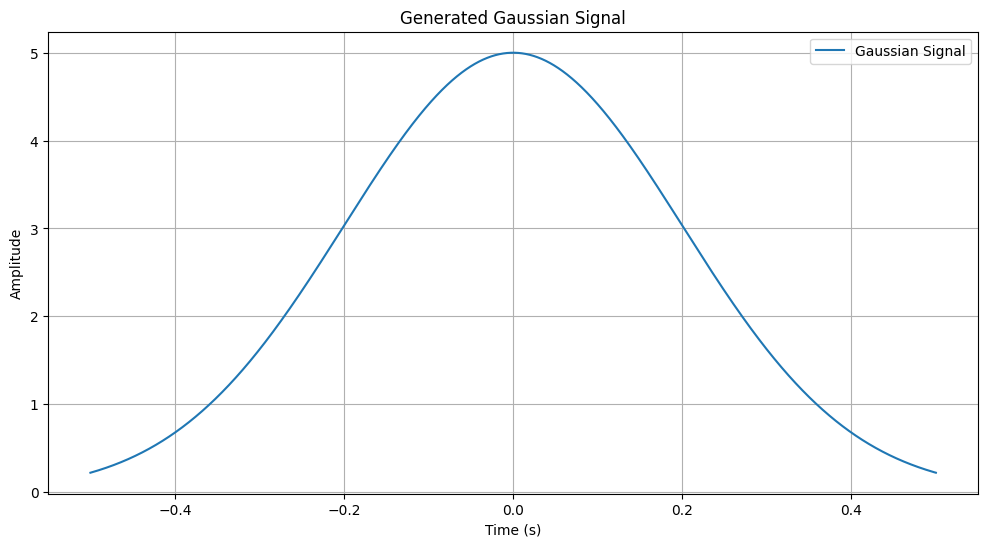

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
total_segments = 50000  # 总数据段数
noise_segments = 10000  # 噪声段数
signal_segments = total_segments - noise_segments  # 包含信号的段数
sampling_rate = 4096  # 采样率（每秒采样数）
duration = 1  # 每段数据的持续时间（秒）
delta_t = 1 / sampling_rate  # 每个采样点的时间间隔

# 噪声与信号的特性
noise_std_1 = 0.5  # 探测器1的噪声标准差
noise_std_2 = 0.6  # 探测器2的噪声标准差
gaussian_amplitude = 5  # 初始信号峰值
gaussian_std = 0.2  # 信号宽度
xi = 0.3  # duty cycle, 信号出现的概率

# 时间序列
time = np.linspace(-duration / 2, duration / 2, int(sampling_rate * duration))

# 生成高斯信号
gaussian_signal = gaussian_amplitude * np.exp(-0.5 * (time / gaussian_std) ** 2)

# 可视化生成的高斯信号
plt.figure(figsize=(12, 6))
plt.plot(time, gaussian_signal, label="Gaussian Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Generated Gaussian Signal")
plt.legend()
plt.grid(True)
plt.show()

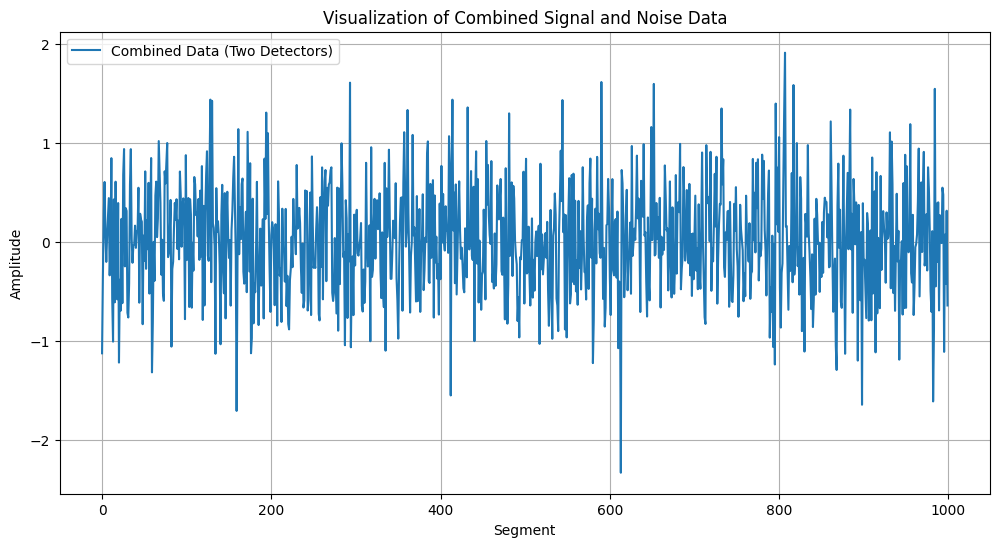

In [2]:
# 两个探测器的噪声
noise_detector_1 = np.random.normal(0, noise_std_1, signal_segments)
noise_detector_2 = np.random.normal(0, noise_std_2, signal_segments)

# 叠加信号与噪声
signal_repeated = np.resize(gaussian_signal, signal_segments)
data_detector_1 = noise_detector_1 + signal_repeated
data_detector_2 = noise_detector_2 + signal_repeated

# 混合信号可视化
combined_data = np.concatenate([noise_detector_1, noise_detector_2])
np.random.shuffle(combined_data)

plt.figure(figsize=(12, 6))
plt.plot(combined_data[:1000], label="Combined Data (Two Detectors)")
plt.xlabel("Segment")
plt.ylabel("Amplitude")
plt.title("Visualization of Combined Signal and Noise Data")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# **信噪比计算 (Cross-Correlation)**
# 定义交叉相关函数
def cross_correlation(data, template):
    data_length = len(data)
    template_length = len(template)
    correlation = np.correlate(data, template, mode='valid')
    return correlation / np.sqrt(np.sum(template**2) * np.sum(data**2))

# 调整信号振幅以提高信噪比
optimized_amplitude = 10  # 目标振幅
gaussian_signal = optimized_amplitude * np.exp(-0.5 * (time / gaussian_std) ** 2)

# 对信号段进行交叉相关
cross_corr_1 = cross_correlation(data_detector_1, gaussian_signal)
cross_corr_2 = cross_correlation(data_detector_2, gaussian_signal)

# 计算信噪比 (SNR)
snr_detector_1 = np.max(cross_corr_1) / np.std(cross_corr_1)
snr_detector_2 = np.max(cross_corr_2) / np.std(cross_corr_2)

print(f"SNR (Detector 1): {snr_detector_1:.2f}")
print(f"SNR (Detector 2): {snr_detector_2:.2f}")

SNR (Detector 1): 4.65
SNR (Detector 2): 4.63


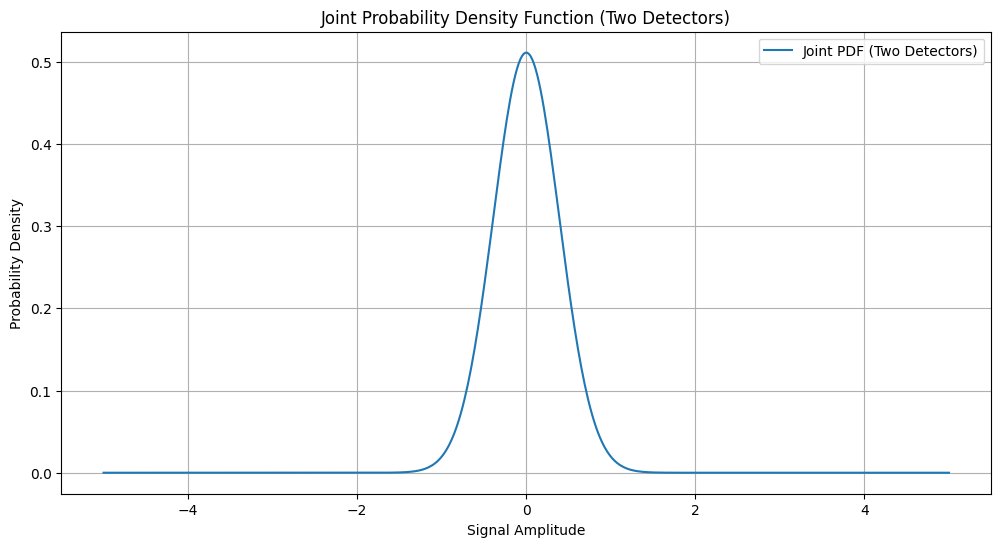

In [4]:
# 单探测器概率密度函数
def single_detector_pdf(s, xi, sigma_n, sigma_h):
    # 信号成分
    signal_component = xi * norm.pdf(s, loc=0, scale=np.sqrt(sigma_h**2 + sigma_n**2))
    # 噪声成分
    noise_component = (1 - xi) * norm.pdf(s, loc=0, scale=sigma_n)
    return signal_component + noise_component

# 联合概率密度函数（两个探测器）
def joint_pdf_two_detectors(s1, s2, xi, sigma_n1, sigma_h1, sigma_n2, sigma_h2):
    pdf1 = single_detector_pdf(s1, xi, sigma_n1, sigma_h1)
    pdf2 = single_detector_pdf(s2, xi, sigma_n2, sigma_h2)
    return pdf1 * pdf2

# 信号幅值范围
s_range = np.linspace(-5, 5, 500)

# 计算联合概率密度
joint_pdf_values = []
for s1, s2 in zip(s_range, s_range):
    joint_pdf_values.append(joint_pdf_two_detectors(s1, s2, xi, noise_std_1, gaussian_std, noise_std_2, gaussian_std))

# 转换为numpy数组
joint_pdf_values = np.array(joint_pdf_values)

# 绘制联合概率密度
plt.figure(figsize=(12, 6))
plt.plot(s_range, joint_pdf_values, label="Joint PDF (Two Detectors)")
plt.xlabel("Signal Amplitude")
plt.ylabel("Probability Density")
plt.title("Joint Probability Density Function (Two Detectors)")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# **计算偏度和峰度**
# 探测器1的信号数据段统计量
data_mean_1 = np.mean(data_detector_1)
data_std_1 = np.std(data_detector_1)

# 三阶累积量（偏度）
skewness_detector_1 = np.sum(((data_detector_1 - data_mean_1) / data_std_1) ** 3) / len(data_detector_1)

# 四阶累积量（峰度）
kurtosis_detector_1 = np.sum(((data_detector_1 - data_mean_1) / data_std_1) ** 4) / len(data_detector_1) - 3

# 使用 Duty Cycle 调整偏度和峰度
skewness_detector_1 *= xi
kurtosis_detector_1 *= xi

# 输出偏度和峰度结果
print(f"Skewness of Signal Data (Detector 1): {skewness_detector_1}")
print(f"Kurtosis of Signal Data (Detector 1): {kurtosis_detector_1}")

# 探测器2的信号数据段统计量
data_mean_2 = np.mean(data_detector_2)
data_std_2 = np.std(data_detector_2)

# 三阶累积量（偏度）
skewness_detector_2 = np.sum(((data_detector_2 - data_mean_2) / data_std_2) ** 3) / len(data_detector_2)

# 四阶累积量（峰度）
kurtosis_detector_2 = np.sum(((data_detector_2 - data_mean_2) / data_std_2) ** 4) / len(data_detector_2) - 3

# 使用 Duty Cycle 调整偏度和峰度
skewness_detector_2 *= xi
kurtosis_detector_2 *= xi

# 输出偏度和峰度结果
print(f"Skewness of Signal Data (Detector 2): {skewness_detector_2}")
print(f"Kurtosis of Signal Data (Detector 2): {kurtosis_detector_2}")

Skewness of Signal Data (Detector 1): 0.03285100611877875
Kurtosis of Signal Data (Detector 1): -0.36934861492273174
Skewness of Signal Data (Detector 2): 0.030138878521333304
Kurtosis of Signal Data (Detector 2): -0.3442820917529036
